In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf


from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import random
from collections import defaultdict

from google.colab import drive 
from sklearn.model_selection import train_test_split




In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
path = 'gdrive/My Drive/MBA_USP/TCC/ifood'
df_ifood_ratings = pd.read_csv(path + '/user_rating_calc.csv',  encoding="utf-8-sig",sep=";")

# Creation of the dataframe. Column names are irrelevant.
ratings_dict = {'itemID': df_ifood_ratings['dishId'],
                'userID': df_ifood_ratings['userId'],
                'rating': df_ifood_ratings['finalRating']}

df = pd.DataFrame(ratings_dict)

In [4]:
data = df
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [5]:
train['itemID'].head()

15900    266cdffd-b169-4dc1-9111-7a1bf178ace2
17034    30d39aa9-3dbf-460b-bebb-c20f2979f8a5
1026     cb19ce14-00c4-4716-965b-0ce8cf841b81
9876     b947b3dc-0260-4259-b11d-2c06584a7d09
4847     016442ba-1d87-42df-a0c8-6a2c461629f1
Name: itemID, dtype: object

## Evaluation

In [6]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = data.set_index('userID')
interactions_train_indexed_df = train.set_index('userID')
interactions_test_indexed_df = test.set_index('userID')

def get_items_interacted(userId, interactions_df):
    if userId not in interactions_df.index:
      return set()
    interacted_items = interactions_df.loc[userId]['itemID']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [7]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:


    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(data['itemID'].unique())
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index

    def evaluate_model_for_user(self, model, person_id):
        #Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        if type(interacted_values_testset['itemID']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['itemID'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['itemID'])])  
        interacted_items_count_testset = len(person_interacted_items_testset) 

        #Getting a ranked recommendation list from a model for a given user
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df), 
                                               topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        #For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            #Getting a random sample (100) items the user has not interacted 
            #(to represent items that are assumed to be no relevant to the user)
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, 
                                                                          sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS)

            #Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            #Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['itemID'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['itemID'].values
            #Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10

        #Recall is the rate of the interacted items that are ranked among the Top-N recommended items, 
        #when mixed with a set of non-relevant items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10}
        return person_metrics

    def evaluate_model(self, model):
        #print('Running evaluation for users')
        people_metrics = []
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            #if idx % 100 == 0 and idx > 0:
            #    print('%d users processed' % idx)
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics) \
                            .sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()  

## Colaborative - AutoEncoder

In [8]:
df_user_dish_rating_matrix = data.pivot(index='userID',columns='itemID', values='rating')
df_user_dish_rating_matrix.fillna(0,inplace=True)

df_user_dish_rating_matrix_train = train.pivot(index='userID',columns='itemID', values='rating')
df_user_dish_rating_matrix_train.fillna(0,inplace=True)
df_user_dish_rating_matrix_train.head()

itemID,000e66a0-1e19-4385-a748-7826478aa152,001cf782-5866-4d67-8871-a28adb58d9aa,003314f9-4399-4032-822f-19c746ca837a,0044680b-2628-4447-a492-eec271ea62cb,006c98af-2c7a-42cf-b64f-3c7e709146b7,00737b3a-b130-47e7-8ef6-469acb2ec1e4,00742dda-ea0a-4c46-b040-121e617b9fe3,0086f944-d4ec-4618-94f3-6060647fc566,00899de3-d612-4eea-b4d3-120faacddbed,008ebd0b-ea7f-469e-9139-c0054d2aa439,00a1ec35-ef18-4b9b-876a-1947710f7925,00ace3a2-cb73-4010-9f02-2a086f085a3a,00c3d7b8-8138-4dfe-b84f-bb2c5f3b2185,00c3fac8-6b07-44d9-932d-9aef93c89f76,00df48bf-7b34-41b3-9c39-fbcb4864ec0c,00f1ce47-45ef-4470-aec4-83fe7035c1f5,00fcd33a-2e7b-48cb-ab25-45fa19860056,00fff2a0-4cf3-4fc4-b423-d0cc5cca97c5,011ce886-7d4d-404e-91cc-da466970b1b0,012b2455-8b31-48b1-91b1-265097dac65c,015a103e-46a9-444f-83ba-52741607dd28,015caaa7-c9f3-449b-9e3d-771617067a52,016442ba-1d87-42df-a0c8-6a2c461629f1,01668891-a543-4376-aca4-4d8039d9439d,0175576d-b3ab-4c2b-a73b-bf344bc62f78,0175df6a-3910-47cc-bcb6-ca3f6d2f83f9,017caea1-29d7-463e-8a8e-8d6b74840238,0198603e-5985-487b-a056-ae9d28a16a0f,0198a146-e5c5-403d-9370-dcef99c63160,01af5ff6-7347-4a82-b9ea-3d4956f90cac,01bb639b-4ed3-4fdb-b66f-3560929d72c1,01c83937-1c9e-431b-8db0-5a272d106663,01d3f391-50cb-48b8-8a61-0395a67487cf,01e3ba11-08b4-44ee-80c0-1a802f365d5d,01ea21f4-65b6-443d-8e43-4c4a9cbfd507,01fbac0a-dd9d-475d-89bc-7a0a81ba9d34,0202171c-9db6-4943-98d5-7c8776264803,0216ae4e-5d15-46f4-9c81-0ae2627c572c,02274f59-32b8-4723-aa83-56dd17a1577b,022a35b1-098c-42d4-baf4-f16503f95567,...,fd38dbba-321e-496f-876a-7673126a1b9b,fd3ec323-dc29-4204-aa3e-4aef6f20b576,fd4f2cc5-9b92-432b-9761-b0dfb0b5ffd8,fd756d12-0047-4b57-9bae-7bb90e5493eb,fd7673fb-6ab5-4259-bf29-25bab3926ea1,fd7d1b3e-abba-4a9a-bc7f-0716055f496a,fd81aed9-11f8-4446-a917-b221bad33349,fd850904-7535-4159-a54f-2bcc6da9c142,fda20bc4-eba7-4f7d-a7ba-e895d619a263,fda56b4f-47ce-4fd3-9a08-4edf4145025c,fdcc3379-dff4-4e82-afa4-e7fdd9afc9ff,fdd3be1d-0499-4aac-846a-223b1ebc4ae0,fde9bc88-3418-424e-9d75-9278367e0430,fdf471b8-70f1-4563-99dc-f724e5c3a541,fdfc9e66-2634-4da6-88eb-ca4f9ab45cd6,fdfdde0f-7950-4046-99b7-d36ef41a7d01,fe0292c1-0811-46a1-bf91-f38b4350a174,fe2cb066-8b62-4c4c-bbf7-48b5c29704e2,fe2e7cb8-0ca1-46e9-844c-38bcaf24fae9,fe2e8770-925e-47e2-8789-278e5d3e4f4f,fe371604-8481-425a-a57f-1cb8968776ba,fe3faae4-f838-4580-909c-b2a32fb3903a,fe427133-d32a-45ed-b1e0-54994f4bcfd3,fe77ed40-f470-4a4e-9e30-512eb8f4f54b,fe8a3ecd-9584-4336-9543-41ee1d4e831e,fec64999-8397-4b61-9e9f-bef3495220cd,fec87a64-8753-4db4-9c75-c86ac427c4be,feceaa21-e727-428e-9c01-6f018d46403a,fef77daf-d5fd-4ffe-88cb-00c0233450fd,ff28bfea-32a0-4db1-8420-b44c3612ffa0,ff31d303-a09d-412b-99fd-5a8e661301b4,ff58aa16-93fb-41a8-ae29-9562b6323f5a,ff6770b4-6d86-40c9-9e6b-1d82cc6f5201,ff714041-921a-4ee9-a5d8-075e0e3364ee,ff74d1d8-d84c-4d75-994b-853f6ef4d68d,ff97b20e-759e-4ff5-99ff-31c50598648f,ff98bb6e-6c47-489e-8d60-3ccf64f309f6,ffc8ab18-4e0f-462c-8a6a-419c4065a665,ffde7d73-fd06-4a9b-8837-d8f293ff8e6d,ffe9617a-cbb3-47e1-9966-524647a60f60
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [9]:
def autoEncoder(shape,layer_size = 2000):
  '''
  Autoencoder for Collaborative Filter Model
  '''

  # Input
  input_layer = Input(shape=(shape[1],), name='UserScore')

  # Encoder
  # -----------------------------
  enc = Dense(layer_size, activation='relu', name='EncLayer1')(input_layer)

  # Latent Space
  # -----------------------------
  lat_space = Dense(layer_size, activation='relu', name='LatentSpace')(enc)
  #lat_space = Dropout(0.2, name='Dropout')(lat_space) # Dropout

  # Decoder
  # -----------------------------
  dec = Dense(layer_size, activation='relu', name='DecLayer1')(lat_space)

  # Output
  output_layer = Dense(shape[1], activation='relu', name='UserScorePred')(dec)

  # this model maps an input to its reconstruction
  model = Model(input_layer, output_layer)    
  print(model.summary())
  return model

In [10]:
def scheduler(epoch, lr):
    if epoch >= 20:
      return lr * tf.math.exp(-0.01)
    return lr

callbacklr = callbacks.LearningRateScheduler(scheduler)

X = df_user_dish_rating_matrix_train.values
y = df_user_dish_rating_matrix_train.values
model = autoEncoder(X.shape)
model.compile(optimizer = Adam(learning_rate=0.0001), loss='mse')
hist = model.fit(x=X, y=y,epochs=50, batch_size=16, callbacks=[callbacklr], shuffle=True, validation_split=0.1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 UserScore (InputLayer)      [(None, 5054)]            0         
                                                                 
 EncLayer1 (Dense)           (None, 2000)              10110000  
                                                                 
 LatentSpace (Dense)         (None, 2000)              4002000   
                                                                 
 DecLayer1 (Dense)           (None, 2000)              4002000   
                                                                 
 UserScorePred (Dense)       (None, 5054)              10113054  
                                                                 
Total params: 28,227,054
Trainable params: 28,227,054
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/50
3/3 [============================

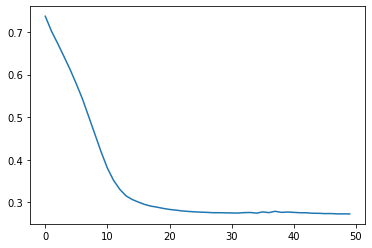

In [11]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [12]:
autoencoder_predictions = model.predict(X)
autoencoder_predictions_df = pd.DataFrame(autoencoder_predictions,columns=df_user_dish_rating_matrix_train.columns,index = df_user_dish_rating_matrix_train.index)
autoencoder_predictions_df.head()

itemID,000e66a0-1e19-4385-a748-7826478aa152,001cf782-5866-4d67-8871-a28adb58d9aa,003314f9-4399-4032-822f-19c746ca837a,0044680b-2628-4447-a492-eec271ea62cb,006c98af-2c7a-42cf-b64f-3c7e709146b7,00737b3a-b130-47e7-8ef6-469acb2ec1e4,00742dda-ea0a-4c46-b040-121e617b9fe3,0086f944-d4ec-4618-94f3-6060647fc566,00899de3-d612-4eea-b4d3-120faacddbed,008ebd0b-ea7f-469e-9139-c0054d2aa439,00a1ec35-ef18-4b9b-876a-1947710f7925,00ace3a2-cb73-4010-9f02-2a086f085a3a,00c3d7b8-8138-4dfe-b84f-bb2c5f3b2185,00c3fac8-6b07-44d9-932d-9aef93c89f76,00df48bf-7b34-41b3-9c39-fbcb4864ec0c,00f1ce47-45ef-4470-aec4-83fe7035c1f5,00fcd33a-2e7b-48cb-ab25-45fa19860056,00fff2a0-4cf3-4fc4-b423-d0cc5cca97c5,011ce886-7d4d-404e-91cc-da466970b1b0,012b2455-8b31-48b1-91b1-265097dac65c,015a103e-46a9-444f-83ba-52741607dd28,015caaa7-c9f3-449b-9e3d-771617067a52,016442ba-1d87-42df-a0c8-6a2c461629f1,01668891-a543-4376-aca4-4d8039d9439d,0175576d-b3ab-4c2b-a73b-bf344bc62f78,0175df6a-3910-47cc-bcb6-ca3f6d2f83f9,017caea1-29d7-463e-8a8e-8d6b74840238,0198603e-5985-487b-a056-ae9d28a16a0f,0198a146-e5c5-403d-9370-dcef99c63160,01af5ff6-7347-4a82-b9ea-3d4956f90cac,01bb639b-4ed3-4fdb-b66f-3560929d72c1,01c83937-1c9e-431b-8db0-5a272d106663,01d3f391-50cb-48b8-8a61-0395a67487cf,01e3ba11-08b4-44ee-80c0-1a802f365d5d,01ea21f4-65b6-443d-8e43-4c4a9cbfd507,01fbac0a-dd9d-475d-89bc-7a0a81ba9d34,0202171c-9db6-4943-98d5-7c8776264803,0216ae4e-5d15-46f4-9c81-0ae2627c572c,02274f59-32b8-4723-aa83-56dd17a1577b,022a35b1-098c-42d4-baf4-f16503f95567,...,fd38dbba-321e-496f-876a-7673126a1b9b,fd3ec323-dc29-4204-aa3e-4aef6f20b576,fd4f2cc5-9b92-432b-9761-b0dfb0b5ffd8,fd756d12-0047-4b57-9bae-7bb90e5493eb,fd7673fb-6ab5-4259-bf29-25bab3926ea1,fd7d1b3e-abba-4a9a-bc7f-0716055f496a,fd81aed9-11f8-4446-a917-b221bad33349,fd850904-7535-4159-a54f-2bcc6da9c142,fda20bc4-eba7-4f7d-a7ba-e895d619a263,fda56b4f-47ce-4fd3-9a08-4edf4145025c,fdcc3379-dff4-4e82-afa4-e7fdd9afc9ff,fdd3be1d-0499-4aac-846a-223b1ebc4ae0,fde9bc88-3418-424e-9d75-9278367e0430,fdf471b8-70f1-4563-99dc-f724e5c3a541,fdfc9e66-2634-4da6-88eb-ca4f9ab45cd6,fdfdde0f-7950-4046-99b7-d36ef41a7d01,fe0292c1-0811-46a1-bf91-f38b4350a174,fe2cb066-8b62-4c4c-bbf7-48b5c29704e2,fe2e7cb8-0ca1-46e9-844c-38bcaf24fae9,fe2e8770-925e-47e2-8789-278e5d3e4f4f,fe371604-8481-425a-a57f-1cb8968776ba,fe3faae4-f838-4580-909c-b2a32fb3903a,fe427133-d32a-45ed-b1e0-54994f4bcfd3,fe77ed40-f470-4a4e-9e30-512eb8f4f54b,fe8a3ecd-9584-4336-9543-41ee1d4e831e,fec64999-8397-4b61-9e9f-bef3495220cd,fec87a64-8753-4db4-9c75-c86ac427c4be,feceaa21-e727-428e-9c01-6f018d46403a,fef77daf-d5fd-4ffe-88cb-00c0233450fd,ff28bfea-32a0-4db1-8420-b44c3612ffa0,ff31d303-a09d-412b-99fd-5a8e661301b4,ff58aa16-93fb-41a8-ae29-9562b6323f5a,ff6770b4-6d86-40c9-9e6b-1d82cc6f5201,ff714041-921a-4ee9-a5d8-075e0e3364ee,ff74d1d8-d84c-4d75-994b-853f6ef4d68d,ff97b20e-759e-4ff5-99ff-31c50598648f,ff98bb6e-6c47-489e-8d60-3ccf64f309f6,ffc8ab18-4e0f-462c-8a6a-419c4065a665,ffde7d73-fd06-4a9b-8837-d8f293ff8e6d,ffe9617a-cbb3-47e1-9966-524647a60f60
userID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,2.970988,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.953573,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.945151,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.028828,0.0,0.0,0.0,0.0,0.0,3.157139,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2.044606,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000

In [13]:
len(autoencoder_predictions[0])

5054

In [14]:
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    
    for index,row in predictions.iterrows():
        user_est_true[row.userID].append((row.predictedRating, row.rating))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [15]:
#def normalize(values, actual_bounds, desired_bounds):
#    return [desired_bounds[0] + (x - actual_bounds[0]) * (desired_bounds[1] - desired_bounds[0]) / (actual_bounds[1] - actual_bounds[0]) for x in values]

user_all_ratings = pd.melt(autoencoder_predictions_df, ignore_index = False)
user_all_ratings = user_all_ratings.rename(columns={'value':'predictedRating'} )
#user_all_ratings['predictedRatingN'] = normalize(user_all_ratings['predictedRating'],(user_all_ratings['predictedRating'].min(),user_all_ratings['predictedRating'].max()),(1,10))

user_all_ratings = user_all_ratings.reset_index()
user_all_ratings.head()

,userID,itemID,predictedRating
0,1,000e66a0-1e19-4385-a748-7826478aa152,0.000000
1,2,000e66a0-1e19-4385-a748-7826478aa152,0.000000
2,3,000e66a0-1e19-4385-a748-7826478aa152,0.000000
3,4,000e66a0-1e19-4385-a748-7826478aa152,2.965286
4,5,000e66a0-1e19-4385-a748-7826478aa152,0.000000


In [16]:
#user_all_ratings[(user_all_ratings['userID'] == 1)]
print(len(train['itemID'].unique()))
print(len(user_all_ratings['itemID'].unique()))
print(len(autoencoder_predictions_df.columns))

5054
5054
5054


In [17]:
#user_rating_calc_train = user_rating_calc_train.drop('Unnamed: 0', axis=1)
user_all_ratings2 = data.merge(user_all_ratings, on=['userID','itemID'])
user_all_ratings2 = user_all_ratings2.fillna(0)
#user_all_ratings2['rating'] = normalize(user_all_ratings2['rating'],(user_all_ratings2['rating'].min(),user_all_ratings2['rating'].max()),(0,1))
#user_all_ratings2['predictedRating'] = user_all_ratings2['predictedRating'].apply(lambda x: np.round(x,4))

np.round

user_all_ratings2['rating'].max()

5

In [18]:
user_all_ratings2[user_all_ratings2['predictedRating'] > 3.5]

,itemID,userID,rating,predictedRating
40,1159c845-985b-4c9d-9b54-70f3f37fc0ec,1,5,5.052659
79,2439dd70-58a1-4690-ab29-6c97d055590d,1,5,5.029646
144,4335ff43-68ce-463c-b43c-be40f34d15c2,1,5,4.975359
163,4ab21505-7480-4375-bdf6-c326b1cf415a,1,5,4.988903
207,6561925f-8c2b-44fe-b4fa-726cb0584891,1,5,4.975825
...,...,...,...,...
19377,9911970d-77f4-412d-b4cd-b3e81d84643a,44,5,5.037086
19383,9b2a72de-19ce-4f96-acaa-cd425bd7a6af,44,5,5.104314
19493,cfe1b561-507e-4401-bdb8-42530dbbc2ec,44,5,4.969305
19506,d8efba21-b75e-40b6-81f5-6e237ab3909a,44,5,4.916612


In [19]:
precisions, recalls = precision_recall_at_k(user_all_ratings2, threshold=3.5)
print(sum(prec for prec in precisions.values()) / len(precisions))
print(sum(rec for rec in recalls.values()) / len(recalls))

#user_all_ratings2.predictedRating.max()
#for index, row in user_all_ratings2.head().iterrows():
#    print(row.userId)

0.8571428571428571
0.20881544888621864
